In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [7]:
fine_periodo = datetime.now() - timedelta(days=1)
inizio_periodo = fine_periodo - timedelta(days=256*40)
tickers = {
    'Oro': 'GC=F',        # Future oro (6091)
    'Azioni': '^GSPC',    # Indice S&P 500  (7055)
    #'Bond': '0P00016UJH.L', # bond global (1243)
    #'Bond': '0GGH.L', # bond global
    #'Bond1': 'GLAU.SW', # bond global 
    'Bond': 'GLAG.L', # bond global  (1735) SPDR Bloomberg Global Aggregate Bond UCITS ETF
    'Tassi': '^TNX',       # Rendimento Treasury 10Y (7042)
   # 'Tassi1': '^IRX',      # Treasury 13 settimane  (7042)
    'Inflazione': 'DBC'   # Commodity Index (4742)
}

In [8]:
def scarica_dati():
    """Scarica i dati storici per gli indicatori chiave."""
    dati_allineati = []
    
    for nome, simbolo in tickers.items():
        try:
            df = yf.download(
                simbolo,
                start=inizio_periodo.strftime('%Y-%m-%d'),
                end=fine_periodo.strftime('%Y-%m-%d'),
                progress=False
            )
            # df is made of Open, High, Close, Volume,etc  + Data as index
            if not df.empty and 'Close' in df.columns:
                df_temp = df['Close'].reset_index()
                # Trasforma l'indice di date in una colonna normale
                # Aggiunge una numerazione progressiva come nuovo indice
                df_temp.columns = ['Data', nome]
                print(f"Size indicatore {nome} è {len(df_temp)} ")
                dati_allineati.append(df_temp)
            else:
                print(f"Nessun dato disponibile per {nome} ({simbolo})")
        
        except Exception as e:
            print(f"Errore durante il download di {nome} ({simbolo}): {e}")
    
    # Unisci tutti i DataFrame usando la colonna Data
    if dati_allineati:
        df_finale = pd.DataFrame()
        for df in dati_allineati:
            if df_finale.empty:
                df_finale = df
            else:
                df_finale = pd.merge(df_finale, df, on='Data', how='inner')
                # on='Data': unisce usando la colonna 'Data' come chiave
                # how='inner': mantiene solo le date presenti in TUTTI i DataFrame
        
        # Imposta la colonna Data come indice
        df_finale.set_index('Data', inplace=True)
        return df_finale
    else:
        raise ValueError("Nessun dato scaricato")

In [9]:
# Scarica i dati
#dati = scarica_dati(tickers, periodo='2y')  # 2 anni per una visione più ampia
dati = scarica_dati()
dati = dati.dropna()  # Rimuove eventuali valori nulli

Size indicatore Oro è 6093 
Size indicatore Azioni è 7054 
Size indicatore Bond è 1737 
Size indicatore Tassi è 7041 
Size indicatore Inflazione è 4744 


In [10]:
len(dati)
dati.head()


,Oro,Azioni,Bond,Tassi,Inflazione
Data,,,,,
2018-01-26,1351.599976,2872.870117,30.000000,2.662,17.25
2018-01-30,1335.400024,2822.429932,29.900000,2.726,17.08
2018-01-31,1339.000000,2823.810059,29.900000,2.720,17.10
2018-02-01,1344.300049,2821.979980,29.900000,2.773,17.27
2018-02-02,1333.699951,2762.129883,29.754999,2.854,16.99


In [ ]:
# METODO 1: Calcolo delle variazioni percentuali mensili
#variazioni = dati.pct_change(periods=252)  # Circa 1 anno
# METODO 2:
# Calcolo della media e deviazione standard mobili su 252 giorni
#rolling_mean = dati.rolling(window=252).mean()
#rolling_std = dati.rolling(window=252).std()
# Calcolo della deviazione standardizzata
#standardized_close = (dati - rolling_mean) / rolling_std

# METODO 3:  Calcolo della media e deviazione standard mobili su tutto il periodo giorni
standardized_close = (dati - dati.mean()) / dati.std()
# the same:
# from scipy import stats
# standardized_close = stats.zscore(dati['VIX'])
# Aggiungilo al dataframe per analisi ulteriori
variazioni = standardized_close


In [26]:
variazioni.tail()

,Oro,Azioni,Bond,Tassi,Inflazione,Stato Ciclo
Data,,,,,,
2024-12-04,0.301074,0.336254,0.019323,-0.035978,-0.084472,0
2024-12-05,0.283083,0.335019,0.014572,-0.021307,-0.092105,0
2024-12-06,0.294637,0.333305,0.018196,-0.046186,-0.083647,0
2024-12-09,0.286770,0.317375,0.014566,-0.006389,-0.070588,0
2024-12-10,0.332741,0.320613,0.013406,-0.015625,-0.062183,0


In [15]:
len(variazioni)
variazioni = variazioni.dropna(how='any')
len(variazioni)

1696

Di fatto ne vengono droppate 20 che corrisponde al (periods=20) in quanto per le prime "periods" righe non si può calcolare la variazione

In [16]:
variazioni.head()

,Oro,Azioni,Bond,Tassi,Inflazione
Data,,,,,
2018-01-26,-1.168607,-1.076649,0.609774,0.028896,-0.488921
2018-01-30,-1.214552,-1.132576,0.570871,0.081634,-0.526755
2018-01-31,-1.204342,-1.131046,0.570871,0.076689,-0.522303
2018-02-01,-1.189311,-1.133075,0.570871,0.120363,-0.484470
2018-02-02,-1.219373,-1.199435,0.514461,0.187109,-0.546784


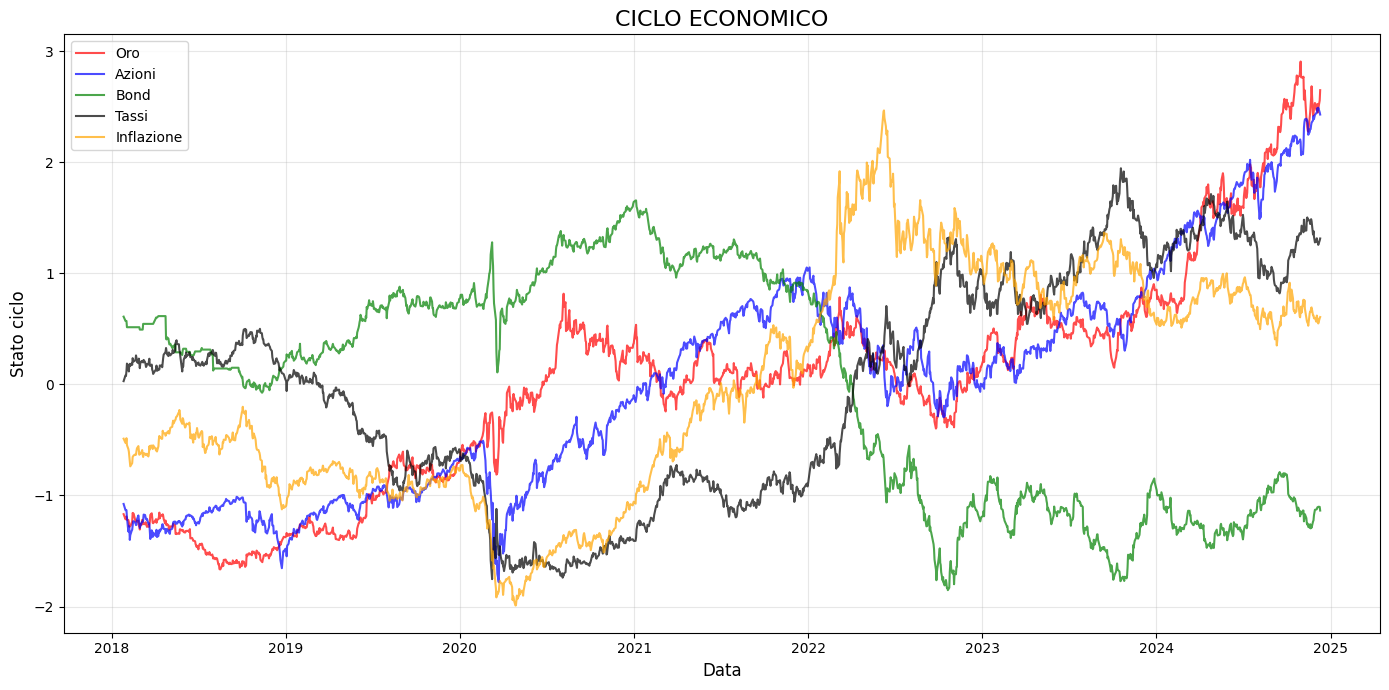

In [17]:
# Creazione del grafico
plt.figure(figsize=(14, 7))
plt.plot(variazioni.index, variazioni['Oro'], label="Oro", color="red", alpha=0.7)
plt.plot(variazioni.index, variazioni['Azioni'], label="Azioni", color="blue", alpha=0.7)
plt.plot(variazioni.index, variazioni['Bond'], label="Bond", color="green", alpha=0.7)
plt.plot(variazioni.index, variazioni['Tassi'], label="Tassi", color="black", alpha=0.7)
plt.plot(variazioni.index, variazioni['Inflazione'], label="Inflazione", color="orange", alpha=0.7)

# Personalizzazione del grafico
plt.title("CICLO ECONOMICO", fontsize=16)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Stato ciclo", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()


plt.show()

In [18]:
# Analisi del ciclo economico
def valuta_ciclo(variazioni):
    stato = []
    for i in range(len(variazioni)):
        oro = variazioni['Oro'].iloc[i]
        azioni = variazioni['Azioni'].iloc[i]
        bond = variazioni['Bond'].iloc[i]
        tassi = variazioni['Tassi'].iloc[i]
        inflazione = variazioni['Inflazione'].iloc[i]

        # Logica di classificazione
        if azioni > 0 and inflazione >= 0:  # Espansione
            stato.append(2)
        elif azioni <= 0 and inflazione >= 0:  # Rallentamento
            stato.append(1)
        elif azioni <= 0 and inflazione <= 0:  # Recessione
            stato.append(-1)
        elif azioni >= 0 and inflazione <= 0:  # Ripresa
            stato.append(0)
        else:
            stato.append(-5) # Indeterminato
    return stato

In [19]:
# METODO 1: Calcolo delle variazioni percentuali mensili
variazioni = dati.pct_change(periods=252)  # Circa 1 anno

In [20]:
len(variazioni)
variazioni = variazioni.dropna(how='any')
len(variazioni)

1444

In [21]:
# Valutazione dello stato del ciclo
variazioni['Stato Ciclo'] = valuta_ciclo(variazioni)

In [22]:
# Filtra le righe in cui la colonna 'Stato Ciclo' è uguale a -5
righe_filtrate = variazioni[variazioni['Stato Ciclo'] == -5]

# Stampa le righe filtrate
print(righe_filtrate)

Empty DataFrame
Columns: [Oro, Azioni, Bond, Tassi, Inflazione, Stato Ciclo]
Index: []


In [23]:
variazioni.tail()

,Oro,Azioni,Bond,Tassi,Inflazione,Stato Ciclo
Data,,,,,,
2024-12-04,0.301074,0.336254,0.019323,-0.035978,-0.084472,0
2024-12-05,0.283083,0.335019,0.014572,-0.021307,-0.092105,0
2024-12-06,0.294637,0.333305,0.018196,-0.046186,-0.083647,0
2024-12-09,0.286770,0.317375,0.014566,-0.006389,-0.070588,0
2024-12-10,0.332741,0.320613,0.013406,-0.015625,-0.062183,0


In [24]:
variazioni

,Oro,Azioni,Bond,Tassi,Inflazione,Stato Ciclo
Data,,,,,,
2019-02-05,-0.027671,-0.047051,-0.032083,0.015026,-0.095652,-1
2019-02-06,-0.019395,-0.032178,-0.029766,-0.008804,-0.085480,-1
2019-02-07,-0.022106,-0.041703,-0.028846,-0.025000,-0.095322,-1
2019-02-08,-0.022763,-0.040433,-0.028261,-0.050847,-0.103069,-1
2019-02-11,-0.020019,-0.018945,-0.026550,-0.067624,-0.093584,-1
...,...,...,...,...,...,...
2024-12-04,0.301074,0.336254,0.019323,-0.035978,-0.084472,0
2024-12-05,0.283083,0.335019,0.014572,-0.021307,-0.092105,0
2024-12-06,0.294637,0.333305,0.018196,-0.046186,-0.083647,0


Creazione grafico

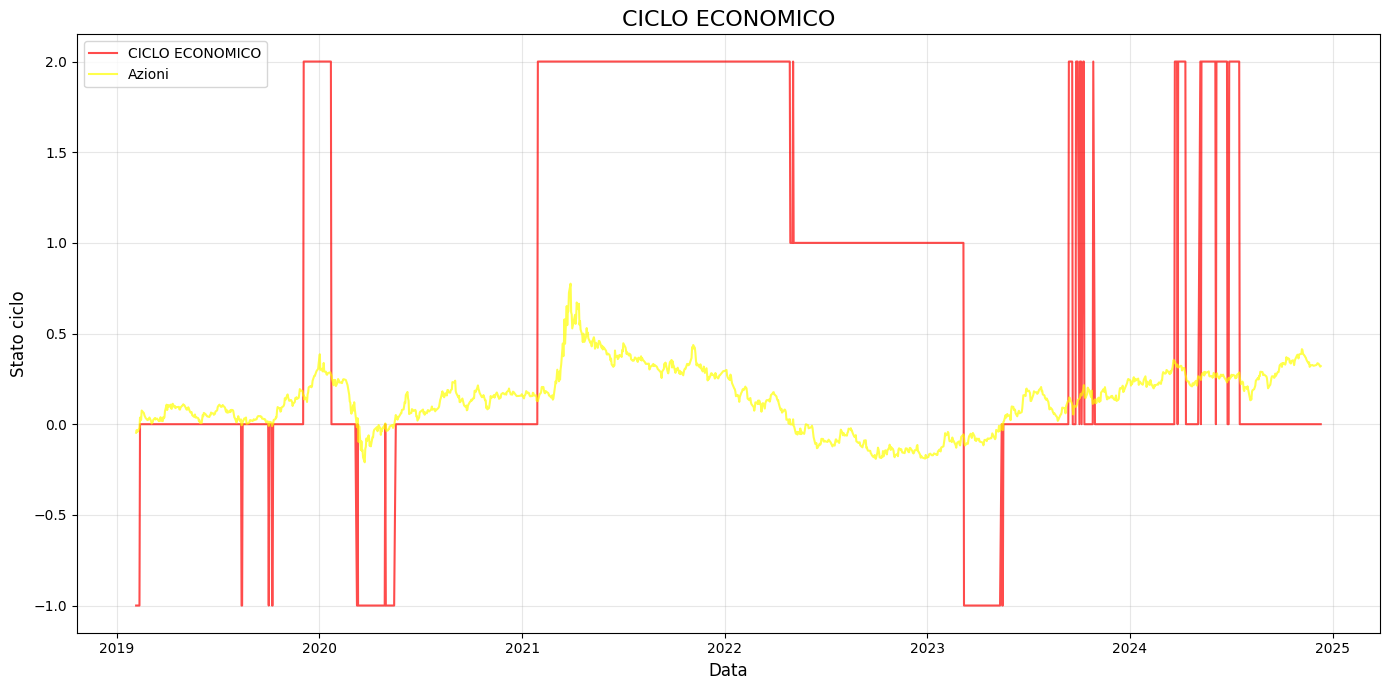

In [25]:
# Creazione del grafico
plt.figure(figsize=(14, 7))
plt.plot(variazioni.index, variazioni['Stato Ciclo'], label="CICLO ECONOMICO", color="red", alpha=0.7)
plt.plot(variazioni.index, variazioni['Azioni'], label="Azioni", color="yellow", alpha=0.7)

# Personalizzazione del grafico
plt.title("CICLO ECONOMICO", fontsize=16)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Stato ciclo", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()


plt.show()


In [125]:
# $ pip install openpyxl
# Salva il DataFrame in un file Excel
variazioni.to_excel('output_completo.xlsx', index=True)